# DDPQ

Here I will use deep deterministic policy gradients (DDPG) to train on the reaching environment with a single agent

---

In this notebook, I use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from d4pg_agent import Agent

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# create agent
agent = Agent(state_size=33, action_size=4, random_seed=20)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def train_ddpg(agent, n_episodes=300, scores= [], scores_deque=deque(maxlen=100)):
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = np.zeros(20)                                          # initialize the score (for each agent)
        for t in range(2000):
            # we will use N=3 bootstrapped return
            # get action
            action = agent.act(state, add_noise=True, episode_num=i_episode) # select an action (for each agent)
            env_info = env.step(action)[brain_name]           # send all actions to tne environment
            # unpack environment variables
            next_state = env_info.vector_observations         # get next state (for each agent)
            reward = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            score += env_info.rewards 
            
            # bootstrap one more action out                     
            next_action = agent.act(next_state, add_noise=True, episode_num=i_episode)
            env_info = env.step(next_action)[brain_name]
            # unpack environment variables
            next_next_state = env_info.vector_observations         # get next state (for each agent)
            next_reward = env_info.rewards                         # get reward (for each agent)
            next_dones = env_info.local_done                        # see if episode finished
            score += env_info.rewards 


            # bootstrap one more action out
            next_next_action = agent.act(next_next_state, add_noise=True, episode_num=i_episode)
            env_info = env.step(next_next_action)[brain_name]
            # unpack environment variables
            next_next_next_state = env_info.vector_observations         # get next state (for each agent)
            next_next_reward = env_info.rewards                         # get reward (for each agent)
            next_next_dones = env_info.local_done                        # see if episode finished
            score += env_info.rewards 

            # experience tuple now allows for 3 step look ahead
            agent.step(state, action, reward, next_state, next_action, next_reward, next_next_state, next_next_action, next_next_reward, next_next_next_state, next_next_dones)
            state = next_next_next_state                               # roll over states to next time step
            if np.any(next_next_dones) or np.any(next_dones) or np.any(dones):                                  # exit loop if episode finished
                break

        scores.append(score)
        scores_deque.append(score)

        # print status every 20 episodes
        if i_episode %2 == 0:
            print('\rEpisode {}\tAverage Score: {:2f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_actor_critic(episode_num=i_episode)
    agent.save_training_run(scores, episode_num=i_episode)
    return scores

Episode 0	Average Score: 0.319500
Episode 2	Average Score: 0.449833
Episode 4	Average Score: 0.482300
Episode 6	Average Score: 0.625643
Episode 8	Average Score: 0.867000
Episode 10	Average Score: 1.222773
Episode 12	Average Score: 1.478885
Episode 14	Average Score: 1.830133
Episode 16	Average Score: 2.432853
Episode 18	Average Score: 3.118737
Episode 20	Average Score: 3.810143
Episode 22	Average Score: 4.748891
Episode 24	Average Score: 5.933900
Episode 26	Average Score: 7.172833
Episode 28	Average Score: 8.163465
Episode 30	Average Score: 9.221709
Episode 32	Average Score: 10.140439
Episode 34	Average Score: 11.057357
Episode 36	Average Score: 12.009513
Episode 38	Average Score: 12.995448
Episode 40	Average Score: 13.955975
Episode 42	Average Score: 14.892604
Episode 44	Average Score: 15.755911
Episode 46	Average Score: 16.598915
Episode 48	Average Score: 17.389928
Episode 50	Average Score: 18.135960
Episode 52	Average Score: 18.869471
Episode 54	Average Score: 19.562045
Episode 56	Av

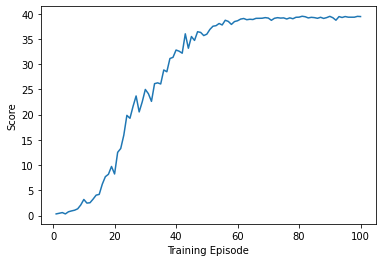

In [4]:
scores = train_ddpg(agent, n_episodes=100)

When finished, you can close the environment.

In [5]:
env.close()